In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.graphics.tsaplots

In [2]:
sns.set(style='whitegrid', palette="Set2", color_codes=True)
%matplotlib inline

In [3]:
Project_Dir = os.getcwd()
Processed_Data_Dir = Project_Dir + r"/Processed_Data"

In [4]:
DATA_UNDLY=pd.read_csv(Processed_Data_Dir+'/Underlyings.csv',usecols=np.arange(1,6),parse_dates=['Date'])

In [5]:
DATA_UNDLY.shape

(4938, 5)

In [6]:
DATA_UNDLY.head()

,Date,Close,Fig,Ten_ma,pct_chg
0,2015-08-20,287.5,GASL,355.7,-0.066558
1,2015-08-21,261.5,GASL,350.3,-0.090435
2,2015-08-24,216.0,GASL,332.7,-0.173996
3,2015-08-25,205.5,GASL,316.1,-0.048611
4,2015-08-26,227.0,GASL,296.7,0.104623


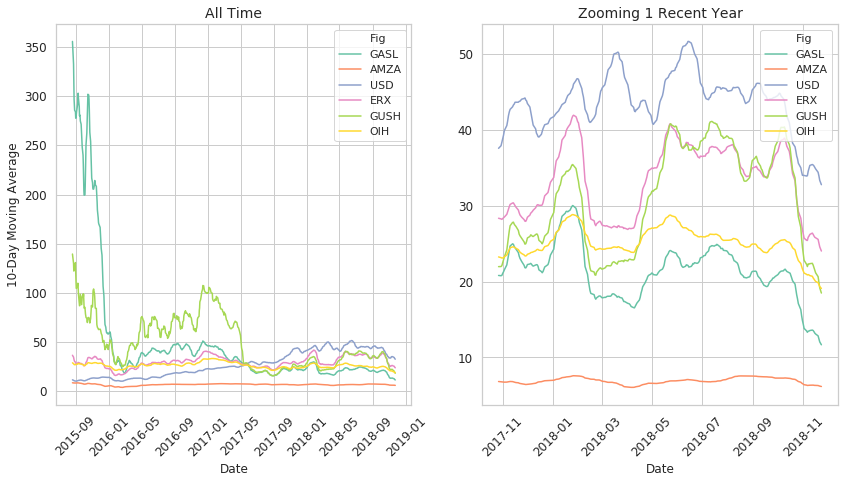

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(data=DATA_UNDLY,hue='Fig',y='Ten_ma',x='Date',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(ylabel='10-Day Moving Average',title='All Time')

sns.lineplot(data=DATA_UNDLY[DATA_UNDLY.Date>"2017-10-26"],hue='Fig',y='Ten_ma',x='Date',ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(ylabel='',title='Zooming 1 Recent Year')
for ax in ax:
    for item in ([ax.yaxis.label,ax.xaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
#     ax.set(title='Suggested Weight Adjustment For KAM\'s Features\n')
    # ax.xaxis.label.set_fontsize(13)
    ax.title.set_fontsize(14)
# plt.show()

In [8]:
dt_undly=DATA_UNDLY

* Get Rid of underlyings with low volatility

# Test GBM's Assumption 

* Correlation

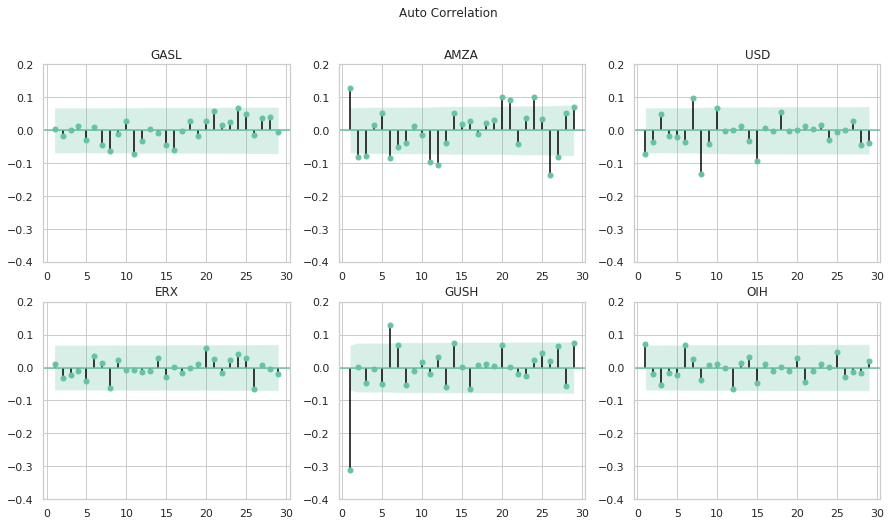

In [9]:
nrow,ncol,ax_ind=2, 3,0
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Auto Correlation')
gs1 = gridspec.GridSpec(nrow,ncol)
ax_ls = [fig.add_subplot(ss) for ss in gs1]
for fig in dt_undly.Fig.unique():
    ax=ax_ls[ax_ind]
    statsmodels.graphics.tsaplots.plot_acf(x=dt_undly[dt_undly.Fig==fig].pct_chg,unbiased=False, lags=np.arange(1,30)
                                           ,alpha=0.05,ax=ax)
    ax.set(title=fig,ylim=(-0.4,0.2))
    ax_ind+=1

* Choose growth window for each underlyinng

Eyball: Choose 2 day as project lap.

In [10]:
g_window=dict(zip(dt_undly.Fig.unique().tolist(),[1,4,4,1,2,3]))
g_window

{'GASL': 1, 'AMZA': 4, 'USD': 4, 'ERX': 1, 'GUSH': 2, 'OIH': 3}

#  Jarque-Bera Test

In [11]:
from scipy.stats import jarque_bera

In [12]:
data_close_pvt=dt_undly[['Date','Close','Fig']].pivot(index='Date',columns='Fig')
data_close_pvt.columns=data_close_pvt.columns.droplevel(0)

In [13]:
data_close_pvt.head().round(2)

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,8.46,32.13,287.5,139.21,27.15,10.58
2015-08-21,8.22,28.83,261.5,125.06,26.26,9.99
2015-08-24,7.92,24.18,216.0,106.41,24.90,9.75
2015-08-25,7.88,23.03,205.5,98.23,24.90,9.37
2015-08-26,8.49,25.43,227.0,104.81,25.84,10.13


In [14]:
jb_result=[]
for col in data_close_pvt.columns:
    window=g_window[col]
    gamma=data_close_pvt[col].pct_change(window)
    jb_result.append(
        [col,window]+
        list(
            jarque_bera(gamma.dropna().values)
        )
    )
pd.DataFrame(jb_result,columns=['Fig','Window','JB_Val','P_Val'])

,Fig,Window,JB_Val,P_Val
0,AMZA,4,1865.309149,0.000000
1,ERX,1,76.445066,0.000000
2,GASL,1,782.893855,0.000000
3,GUSH,2,3024.206357,0.000000
4,OIH,3,102.606641,0.000000
5,USD,4,22.862180,0.000011


# Generate Underlying Price 

* Sample Path Span

In [15]:
DATA_OPT=pd.read_csv(Processed_Data_Dir+'/Options.csv',index_col=[0],parse_dates=['Maturity','D2M'])

DATA_OPT.D2M=pd.to_timedelta(DATA_OPT.D2M)

In [16]:
DATA_OPT.head()

,Maturity,Fig,Strike,Ask_p,D2M
0,2018-12-21,GASL,1.0,0.55,28 days
1,2018-12-21,GASL,2.0,0.55,28 days
2,2018-12-21,GASL,3.0,0.55,28 days
3,2018-12-21,GASL,4.0,0.55,28 days
4,2018-12-21,GASL,5.0,0.75,28 days


In [17]:
DATA_OPT.groupby(['D2M','Fig'],group_keys=False).agg({'Fig':'count'})

Fig
D2M      Fig      
14 days  ERX    16
         OIH    11
21 days  ERX    16
         OIH    12
25 days  GUSH    1
28 days  AMZA    6
         ERX    16
         GASL    9
         GUSH    6
         OIH    13
         USD    10
35 days  ERX    15
         OIH    11
42 days  ERX    17
         OIH    10
49 days  ERX    16
         OIH    10
56 days  AMZA    6
         ERX     4
         GASL    8
         GUSH    8
         OIH     9
         USD    15
84 days  ERX    11
         GASL    8
         GUSH    7
         USD    12
112 days AMZA    6
         GASL    7
         GUSH    3
146 days ERX     7
         OIH    10
175 days USD     7
210 days GUSH    3
420 days GUSH    3
784 days GUSH    3

In [18]:
Gen_Span=pd.Timedelta(56,'D')

In [19]:
dt_option=DATA_OPT[DATA_OPT.D2M<=Gen_Span]

In [20]:
dt_option.shape,dt_option.columns

((245, 5),
 Index(['Maturity', 'Fig', 'Strike', 'Ask_p', 'D2M'], dtype='object'))

* Mean, Std, Corr

In [21]:
dt_gamma=pd.DataFrame([])
for col in data_close_pvt.columns:
    window=g_window[col]
    dt_gamma[col]=data_close_pvt[col].pct_change(window)

In [22]:
dt_gamma.mean()

AMZA   -0.000228
ERX     0.000339
GASL   -0.001355
GUSH    0.026784
OIH    -0.000638
USD     0.007054
dtype: float64

In [23]:
dt_gamma.head()

,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-21,NaN,-0.102775,-0.090435,NaN,NaN,NaN
2015-08-24,NaN,-0.161115,-0.173996,-0.235652,NaN,NaN
2015-08-25,NaN,-0.047812,-0.048611,-0.214581,-0.082730,NaN
2015-08-26,0.0031,0.104255,0.104623,-0.015018,-0.016037,-0.042452


In [24]:
nTrial=10000
Start_Date=pd.to_datetime('2017-9-1')
Gen_Mean,Gen_Cov=dt_gamma[dt_gamma.index>Start_Date].mean(),dt_gamma[dt_gamma.index>Start_Date].cov()


In [25]:
sim_gamma=np.random.multivariate_normal(mean=Gen_Mean,cov=Gen_Cov,size=(nTrial,Gen_Span.days+10))

In [26]:
sim_gamma.shape

(10000, 66, 6)

In [27]:
sim_gamma=dict(zip(dt_gamma.columns.tolist(),[sim_gamma[:,:,fig] for fig in range(sim_gamma.shape[2])]))

In [28]:
sim_gamma['GUSH'].shape

(10000, 66)

In [29]:
data_close_pvt.head().round(2)

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2015-08-20,8.46,32.13,287.5,139.21,27.15,10.58
2015-08-21,8.22,28.83,261.5,125.06,26.26,9.99
2015-08-24,7.92,24.18,216.0,106.41,24.90,9.75
2015-08-25,7.88,23.03,205.5,98.23,24.90,9.37
2015-08-26,8.49,25.43,227.0,104.81,25.84,10.13


In [30]:
# sim_undly={}
# sim_g_rshp={}
# for key,val in sim_gamma.items():
#     print(key,val.shape)
#     window=g_window[key]
#     less=val.shape[1]%window
#     if window!=1:                
#         new_sim=val[:,:-less] if less!=0 else val
#         sim_g_rshp[key]=new_sim.reshape(nTrial,new_sim.shape[1]//window,window)
#     else:
#         sim_g_rshp[key]=val
#     print('\t',window,less,sim_g_rshp[key].shape)    
#     s0=data_close_pvt[key][-window:].values
#     cum_g=(sim_g_rshp[key]+1).cumprod(axis=1)
#     print('\t',s0.shape,cum_g.shape)
#     sim_undly[key]=(s0*cum_g).reshape(nTrial,-1)[:,:Gen_Span.days]   
#     print('\t',sim_undly[key].shape)

In [31]:
sim_undly={}
sim_factor={}
for key,val in sim_gamma.items():
    window=g_window[key]
    sim_factor[key]=(val+1)**(1/window)
    s0=data_close_pvt[key][-1]
    cum_g=sim_factor[key].cumprod(axis=1)
    sim_undly[key]=(s0*cum_g).reshape(nTrial,-1)[:,:Gen_Span.days]   

In [32]:
class sim_result:
    def __init__(self, sim_undly):
        self.underlying=sim_undly
        self.max=sim_undly[list(sim_undly.keys())[0]].shape[0]
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n <= self.max:
            sim_undly0={}
            for key,val in self.underlying.items():
                sim_undly0[key]=val[self.n]
            sim_undly0=pd.DataFrame(sim_undly0)
            sim_undly0_longform=sim_undly0.reset_index().melt(id_vars=['index'],var_name='fig',value_name='close')
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            sns.lineplot(data=sim_undly0_longform,hue='fig',y='close',x='index')
            self.n += 1
            print(self.n)
        else:
            raise StopIteration

In [33]:
sim_iter=iter(sim_result(sim_undly))

93


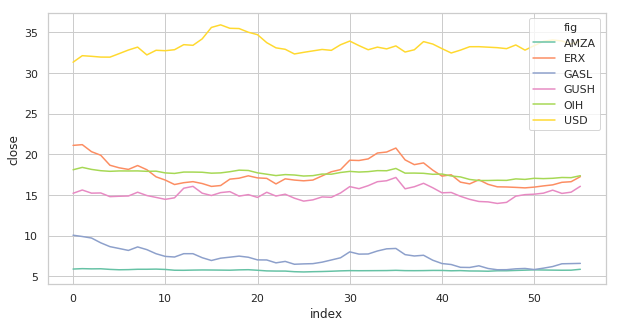

In [128]:
next(sim_iter)

# Appendix

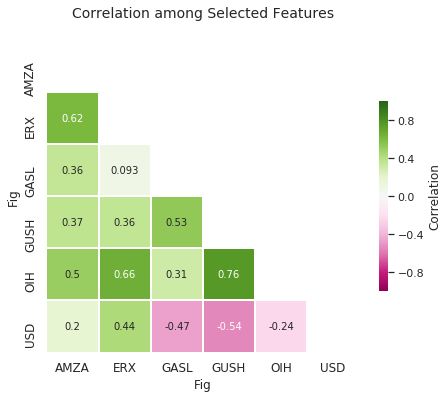

In [35]:
corr=data_close_pvt.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(7, 7))
with sns.axes_style(style='white'):
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1,
                     square=True,
#                      xticklabels=labs_heatmap_x,
#                      yticklabels=labs_heatmap_y,
                     center=0,
                     annot=True,
                     # ax=ax,
                     cmap="PiYG",
                     linewidths=.5,
                     cbar_kws={"shrink": .5,
                               'label': 'Correlation'
                               }
                     )
for item in ([ax.yaxis.label,ax.xaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
ax.set(title='Correlation among Selected Features\n')
ax.title.set_fontsize(14)
plt.show()


In [36]:
data_chg_pvt=data[['Date','pct_chg','Fig']].pivot(index='Date',columns='Fig')
data_chg_pvt.columns=data_chg_pvt.columns.droplevel(0)

NameError: name 'data' is not defined

In [ ]:
data_chg_pvt.head().round(3)

In [ ]:
data_chg_pvt.describe()[1:3]

In [ ]:
def sim_NTL(mu,cov,NTR):
    result=[]
    for n in range(NTR):    
        z_sim=np.column_stack([np.random.multivariate_normal(1+mu,cov,24),[1.0085]*24])    
        result.append(np.append(z_sim.prod(0),
                                [z_sim.prod(0).mean(),z_sim.mean(1).prod()])*100)
    return result